In [0]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import fastai
import torch
from fastai.tabular import *
from fastai.vision import *
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from psutil import virtual_memory

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(0))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Using device: cuda
Tesla P100-PCIE-16GB
Fri Apr 24 01:05:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                    

In [5]:
spectogram_folder = "/content/drive/My Drive/metal_spectograms/"
spotify_data = pd.read_csv("/content/drive/My Drive/metal_track_data.csv")
del spotify_data['Unnamed: 0']
spotify_data.sample(5)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,acousticness,artist_ids,artist_names,danceability,duration_ms,energy,explicit,label,instrumentalness,key,liveness,loudness,mode,num_sections,popularity,preview_url,speechiness,tempo,time_signature,image_path,track_name,uri,valence
23986,0.000001,['0kKZER84faGrJPHtH8NdqH'],['Gadget'],0.189,144906,0.859,0,grindcore,0.874000,0.0,0.2480,-6.598,1.0,7.0,3,https://p.scdn.co/mp3-preview/3f772db6e7abdb72...,0.0802,126.369,4.0,6a/6AT8sHyXL9QvZkvr3KeFIj.png,The Anchor,spotify:track:6AT8sHyXL9QvZkvr3KeFIj,0.149
72146,0.001600,['2kfVqdz3lJshqH9GUHhtMr'],['Psychostick'],0.527,143658,0.916,0,nu metal,0.000013,6.0,0.1170,-6.875,1.0,8.0,29,https://p.scdn.co/mp3-preview/3692471d62dbf044...,0.0774,133.858,4.0,4z/4ZgByupaV6RxEzxM3LXrst.png,Mi Queso,spotify:track:4ZgByupaV6RxEzxM3LXrst,0.456
114871,0.001030,['1U3sDWs6O3xDK5soNcuKEZ'],['RKL'],0.376,151600,0.867,0,punk,0.225000,2.0,0.0621,-8.684,1.0,9.0,6,https://p.scdn.co/mp3-preview/28c6ecce9850a92f...,0.1010,143.416,4.0,3i/3IRDV4zvdPOe7kqf5jAuHY.png,Motherfucker,spotify:track:3IRDV4zvdPOe7kqf5jAuHY,0.51
89003,0.000217,['4BxPAlkpM9WCW8HkRLCl3J'],['Zombie Girl'],0.356,204373,0.775,0,industrial metal,0.944000,2.0,0.0916,-8.868,1.0,10.0,4,https://p.scdn.co/mp3-preview/073cfa290265d1cf...,0.0754,150.051,4.0,7k/7kUhr4UUMIPEiC77csDF7K.png,Gonna Getcha - Drone Remix,spotify:track:7kUhr4UUMIPEiC77csDF7K,0.0593
68312,0.000498,['2yeEmsTQMNHBlS5dhWtuD1'],['Pallbearer'],0.261,616711,0.805,0,doom metal,0.479000,2.0,0.2670,-6.085,1.0,15.0,29,https://p.scdn.co/mp3-preview/d36e34274281c24c...,0.0516,116.862,4.0,6s/6SbqCMWpmTtovRda3V0aCM.png,Worlds Apart,spotify:track:6SbqCMWpmTtovRda3V0aCM,0.292


In [6]:
#merge small sub-subgenres into their parents
spotify_data.loc[spotify_data.label == 'depressive black metal', 'label'] = 'black metal'
spotify_data.loc[spotify_data.label == 'slam death metal', 'label'] = 'death metal'
spotify_data.loc[spotify_data.label == 'blackgaze', 'label'] = 'black metal'
spotify_data.loc[spotify_data.label == 'sludge metal', 'label'] = 'doom metal'
spotify_data.loc[spotify_data.label == 'funeral doom', 'label'] = 'doom metal'
spotify_data.loc[spotify_data.label == 'technical death metal', 'label'] = 'death metal'
spotify_data.loc[spotify_data.label == 'goregrind', 'label'] = 'grindcore'

#drop a few of the subgenres with small sets
spotify_data = spotify_data[spotify_data.label != 'nwobhm']
spotify_data = spotify_data[spotify_data.label != 'crust punk']
spotify_data = spotify_data[spotify_data.label != 'mathcore']
spotify_data = spotify_data[spotify_data.label != 'drone metal']
spotify_data = spotify_data[spotify_data.label != 'djent']

spotify_data['label'].value_counts()

punk                   12645
hard rock               8335
death metal             7847
screamo                 7582
doom metal              6927
grindcore               6886
black metal             6610
nu metal                5948
industrial metal        5902
power metal             5587
metalcore               5521
thrash metal            5343
hardcore                5284
melodic death metal     5034
progressive metal       4562
symphonic metal         4294
stoner rock             4280
glam metal              4046
folk metal              3670
deathcore               3514
Name: label, dtype: int64

In [0]:
label_encoder = preprocessing.LabelEncoder()
spotify_data['label'] = label_encoder.fit_transform(spotify_data['label'].astype('str'))

In [0]:
#process the data into a format which can be made into a databunch

cont_names = ['acousticness', 'danceability', 'duration_ms', 'energy', 
              'instrumentalness', 'liveness', 'loudness', 'num_sections', 
              'popularity', 'speechiness', 'tempo', 'time_signature', 'valence']
cat_names = ['explicit', 'key', 'mode']
image_list_names = ['image_path', 'track_name', 'artist_names', 'label']

def make_mixed_item_list(df):
    df = remove_null_values(df)
    tabular_list = make_tabular_list(df)
    image_list = make_image_list(df)
    return MixedItemList(item_lists=[image_list, tabular_list], inner_df=df)

def remove_null_values(df):
    for col in cont_names + cat_names:
        df = df[pd.to_numeric(df[col], errors='coerce').notnull()]
    return df
    
def make_tabular_list(df):
    cont_data = df[cont_names].astype(float)
    cat_data = df[cat_names].astype('category')
    tabular_data = pd.concat([cont_data, cat_data], axis=1, sort=False)
    return TabularList.from_df(df=tabular_data, 
                               cat_names=cat_names, 
                               cont_names=cont_names, 
                               procs=[FillMissing, Normalize])
    
def make_image_list(df):
    return ImageList.from_df(df=df[image_list_names], 
                                   path=spectogram_folder, 
                                   cols='image_path', 
                                   convert_mode='L')

In [0]:
batch_size = 64
num_workers = 16

x_train, x_test = train_test_split(spotify_data, test_size=0.2, random_state=42)
mixed_list = make_mixed_item_list(x_train)
data = (mixed_list
        .split_by_rand_pct(0.2, seed=42)
        .label_from_df(cols='label')
        .databunch(bs=batch_size, num_workers=num_workers))

In [0]:
class CRNN(nn.Module):
    def __init__(self, crnn_channels, fcn_channels, tabular_data_size, num_classes):
        super(CRNN, self).__init__()
        self.cnn = CNN(crnn_channels)
        self.rnn = RNN(crnn_channels)
        self.fcn = FCN(tabular_data_size, fcn_channels)
        self.final_layer = nn.Linear(crnn_channels + fcn_channels, num_classes)

    def forward(self, image_input, tabular_input):
        cnn_output = self.cnn(image_input) # [batch, channel, decibels, time]
        rnn_input = cnn_output.squeeze().permute(0, 2, 1)
        rnn_output = self.rnn(rnn_input) # [batch, sequence, features]
        fcn_output = self.fcn(tabular_input)
        concat_data = torch.cat((rnn_output, fcn_output), dim=1)
        output = self.final_layer(concat_data)
        return F.log_softmax(output, dim=1)

class CNN(nn.Module):
    def __init__(self, num_channels):
        super(CNN, self).__init__()
        self.conv1 = self.make_conv_layer(1, num_channels, 2)
        self.conv2 = self.make_conv_layer(num_channels, num_channels, 2)
        self.conv3 = self.make_conv_layer(num_channels, num_channels, 2)
        self.conv4 = self.make_conv_layer(num_channels, num_channels, (4, 2))
        self.conv5 = self.make_conv_layer(num_channels, num_channels, (4, 4))
    
    def make_conv_layer(self, in_channels, out_channels, max_pool_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(),
            nn.MaxPool2d(max_pool_size))

    def forward(self, input):
        feature_map = self.conv1(input)
        feature_map = self.conv2(feature_map)
        feature_map = self.conv3(feature_map)
        feature_map = self.conv4(feature_map)
        return self.conv5(feature_map)

class RNN(nn.Module):
    def __init__(self, num_channels):
        super(RNN, self).__init__()
        self.gru = nn.GRU(num_channels, num_channels, num_layers=2, batch_first=True)
        self.fc = nn.Linear(20 * num_channels, num_channels)

    def forward(self, input):
        gru_output, _ = self.gru(input)
        linear_input = gru_output.contiguous().view(gru_output.size(0), -1)
        return self.fc(linear_input)

class FCN(nn.Module):
    def __init__(self, tabular_data_size, num_channels):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(tabular_data_size, num_channels)
        self.fc2 = nn.Linear(num_channels, num_channels)
    
    def forward(self, tabular_data):
        cat_data, cont_data = tabular_data
        tabular_data = torch.cat((cat_data.float(), cont_data), dim=1)
        tabular_data = F.relu(self.fc1(tabular_data))
        return F.relu(self.fc2(tabular_data))

In [0]:
crnn_channels = 64
fcn_channels = 32
track_data_size = len(cont_names + cat_names)
num_classes = len(spotify_data['label'].unique())

model = CRNN(crnn_channels, fcn_channels, track_data_size, num_classes)
if torch.cuda.is_available():
    model = model.to(device)
learn = Learner(data, model, metrics=[accuracy])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 3.02E-04


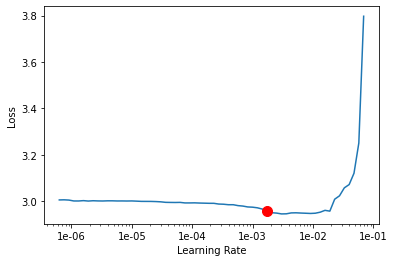

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.recorder.min_grad_lr

0.001737800828749376

In [0]:
learn.fit_one_cycle(cyc_len=10, max_lr=learn.recorder.min_grad_lr, wd=0.01)
learn.save('crnn_concat_metal_model', return_path=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.918854,2.118646,0.333740,58:37
1,1.691056,2.527938,0.290610,1:00:02
2,1.544799,1.828680,0.425358,47:45
3,1.391304,1.542107,0.501751,57:52
4,1.323522,1.561493,0.506950,51:36
5,1.171780,1.456072,0.539151,48:22
6,1.054877,1.409251,0.554483,1:04:24
7,0.887406,1.244829,0.608541,54:40
8,0.775523,1.204884,0.629761,54:38
9,0.687387,1.206033,0.629602,1:05:04


PosixPath('/content/drive/My Drive/metal_spectograms/models/crnn_concat_metal_model.pth')

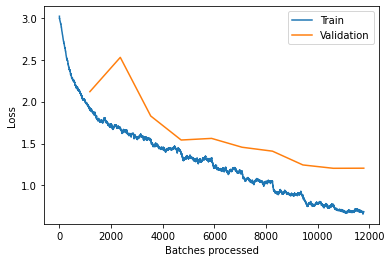

In [0]:
learn.recorder.plot_losses()

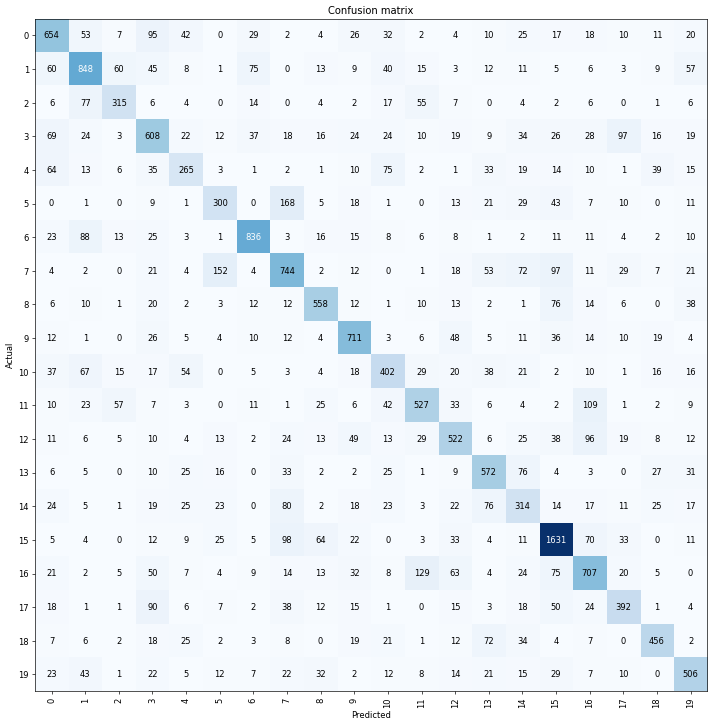

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [0]:
print("Most confused pairs of subgenres:\n")
class_names = label_encoder.inverse_transform(spotify_data['label'].unique())
for confused in interp.most_confused(min_val=80):
    print("{0} was confused with {1} {2} times."
    .format(class_names[confused[0]], class_names[confused[1]], confused[2]))

Most confused pairs of subgenres:

hard rock was confused with industrial metal 168 times.
industrial metal was confused with hard rock 152 times.
grindcore was confused with progressive metal 129 times.
progressive metal was confused with grindcore 109 times.
stoner rock was confused with industrial metal 98 times.
nu metal was confused with folk metal 97 times.
industrial metal was confused with stoner rock 97 times.
deathcore was confused with grindcore 96 times.
thrash metal was confused with nu metal 95 times.
folk metal was confused with nu metal 90 times.
punk was confused with glam metal 88 times.
melodic death metal was confused with industrial metal 80 times.


In [12]:
model_path = "/content/drive/My Drive/models/crnn_concat_metal_model"
learn.load(model_path, device=device)

Learner(data=DataBunch;

Train: LabelList (75403 items)
x: MixedItemList
MixedItem
Image (1, 128, 1292)
TabularLine explicit 0; key 2.0; mode 1.0; acousticness -0.3706; danceability -0.5787; duration_ms 0.7918; energy 0.3436; instrumentalness 0.3155; liveness -0.7243; loudness -0.2822; num_sections 0.3064; popularity 0.3224; speechiness -0.2719; tempo 0.3450; time_signature 0.2673; valence -0.0231; ,MixedItem
Image (1, 128, 1292)
TabularLine explicit 0; key 11.0; mode 1.0; acousticness -0.3670; danceability 1.1523; duration_ms 1.0932; energy -0.0911; instrumentalness 0.9904; liveness -0.1829; loudness -0.2270; num_sections 0.6950; popularity -0.2412; speechiness -0.5126; tempo 0.3116; time_signature 0.2673; valence -0.0180; ,MixedItem
Image (1, 128, 1292)
TabularLine explicit 1; key 9.0; mode 1.0; acousticness -0.3693; danceability 1.0967; duration_ms -1.1127; energy -0.3877; instrumentalness -0.7692; liveness -0.7780; loudness -0.2122; num_sections -0.8596; popularity 1.5434; speechin

In [0]:
test_list = make_mixed_item_list(x_test)
learn.data.add_test(test_list)
probs, _ = learn.get_preds(ds_type=DatasetType.Test)
y_test = remove_null_values(x_test)['label'].copy()

In [35]:
def calculate_accuracy(predictions, answers):
    score = 0
    for i in range(len(answers)):
        if answers[i] in predictions[i]:
            score += 1
    return score / len(answers)

print("Test set accuracy scores:\n")

#top1
pred_class = torch.argmax(probs, dim=1)
answers = y_test.tolist()
score = calculate_accuracy(pred_class, answers)
print("Top 1: {0:.2f}%".format(score * 100))

#top5
top_classes = np.argsort(probs, axis=1)[:,-5:]
score = calculate_accuracy(top_classes, answers)
print("Top 5: {0:.2f}%".format(score * 100))

Test set accuracy scores:

Top 1: 62.74%
Top 5: 92.96%
